<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S8/ERAV2_S8_LN_Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
    ]
)


In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 47852648.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


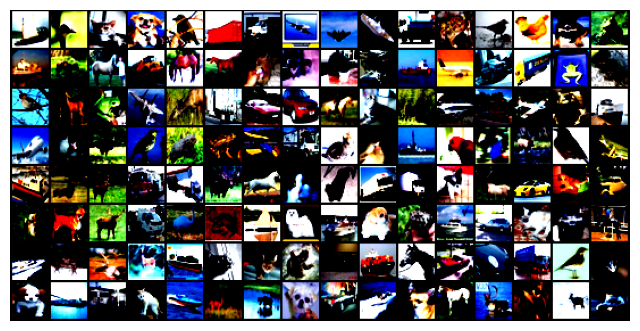

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [13]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       # C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([4, 32, 32]),
            nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8, 32, 32]),
            nn.Dropout(dropout_value)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([4, 16, 16]),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8, 16, 16]),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 16, 16]),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8, 8, 8]),
            nn.Dropout(dropout_value)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 8, 8]),
            nn.Dropout(dropout_value)
        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, 8, 8]),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             108
              ReLU-2            [-1, 4, 32, 32]               0
         LayerNorm-3            [-1, 4, 32, 32]           8,192
           Dropout-4            [-1, 4, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             288
              ReLU-6            [-1, 8, 32, 32]               0
         LayerNorm-7            [-1, 8, 32, 32]          16,384
           Dropout-8            [-1, 8, 32, 32]               0
            Conv2d-9            [-1, 4, 32, 32]              32
        MaxPool2d-10            [-1, 4, 16, 16]               0
           Conv2d-11            [-1, 4, 16, 16]             144
             ReLU-12            [-1, 4, 16, 16]               0
        LayerNorm-13            [-1, 4, 16, 16]           2,048
          Dropout-14            [-1, 4,

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass
              #print('error:',e,misclassified_indices,misclassified_pred_labels)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8210493326187134 Batch_id=390 Accuracy=23.29: 100%|██████████| 391/391 [00:16<00:00, 23.75it/s]



Test set: Average loss: 1.8117, Accuracy: 2979/10000 (29.79%)

EPOCH: 1


Loss=1.6385160684585571 Batch_id=390 Accuracy=33.71: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]



Test set: Average loss: 1.6929, Accuracy: 3508/10000 (35.08%)

EPOCH: 2


Loss=1.5726072788238525 Batch_id=390 Accuracy=40.34: 100%|██████████| 391/391 [00:16<00:00, 24.10it/s]



Test set: Average loss: 1.6194, Accuracy: 4010/10000 (40.10%)

EPOCH: 3


Loss=1.5437027215957642 Batch_id=390 Accuracy=44.57: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]



Test set: Average loss: 1.4791, Accuracy: 4577/10000 (45.77%)

EPOCH: 4


Loss=1.5199593305587769 Batch_id=390 Accuracy=47.18: 100%|██████████| 391/391 [00:16<00:00, 24.32it/s]



Test set: Average loss: 1.4016, Accuracy: 4817/10000 (48.17%)

EPOCH: 5


Loss=1.484296202659607 Batch_id=390 Accuracy=49.85: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s]



Test set: Average loss: 1.3283, Accuracy: 5235/10000 (52.35%)

EPOCH: 6


Loss=1.1922662258148193 Batch_id=390 Accuracy=53.15: 100%|██████████| 391/391 [00:15<00:00, 24.75it/s]



Test set: Average loss: 1.2753, Accuracy: 5411/10000 (54.11%)

EPOCH: 7


Loss=1.2927050590515137 Batch_id=390 Accuracy=53.37: 100%|██████████| 391/391 [00:16<00:00, 23.91it/s]



Test set: Average loss: 1.2757, Accuracy: 5401/10000 (54.01%)

EPOCH: 8


Loss=1.3295366764068604 Batch_id=390 Accuracy=53.85: 100%|██████████| 391/391 [00:15<00:00, 24.56it/s]



Test set: Average loss: 1.2699, Accuracy: 5442/10000 (54.42%)

EPOCH: 9


Loss=1.3919861316680908 Batch_id=390 Accuracy=53.97: 100%|██████████| 391/391 [00:16<00:00, 24.42it/s]



Test set: Average loss: 1.2581, Accuracy: 5466/10000 (54.66%)

EPOCH: 10


Loss=1.1919581890106201 Batch_id=390 Accuracy=54.18: 100%|██████████| 391/391 [00:16<00:00, 24.26it/s]



Test set: Average loss: 1.2516, Accuracy: 5487/10000 (54.87%)

EPOCH: 11


Loss=1.1073713302612305 Batch_id=390 Accuracy=54.10: 100%|██████████| 391/391 [00:16<00:00, 24.39it/s]



Test set: Average loss: 1.2485, Accuracy: 5528/10000 (55.28%)

EPOCH: 12


Loss=1.4198120832443237 Batch_id=390 Accuracy=54.49: 100%|██████████| 391/391 [00:16<00:00, 24.17it/s]



Test set: Average loss: 1.2391, Accuracy: 5552/10000 (55.52%)

EPOCH: 13


Loss=1.2008345127105713 Batch_id=390 Accuracy=54.68: 100%|██████████| 391/391 [00:16<00:00, 24.16it/s]



Test set: Average loss: 1.2364, Accuracy: 5576/10000 (55.76%)

EPOCH: 14


Loss=1.3035839796066284 Batch_id=390 Accuracy=54.79: 100%|██████████| 391/391 [00:16<00:00, 23.85it/s]



Test set: Average loss: 1.2365, Accuracy: 5569/10000 (55.69%)

EPOCH: 15


Loss=1.3669850826263428 Batch_id=390 Accuracy=54.63: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]



Test set: Average loss: 1.2379, Accuracy: 5550/10000 (55.50%)

EPOCH: 16


Loss=1.3410723209381104 Batch_id=390 Accuracy=54.82: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]



Test set: Average loss: 1.2372, Accuracy: 5549/10000 (55.49%)

EPOCH: 17


Loss=1.4067466259002686 Batch_id=390 Accuracy=54.86: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s]



Test set: Average loss: 1.2361, Accuracy: 5560/10000 (55.60%)

EPOCH: 18


Loss=1.0721051692962646 Batch_id=390 Accuracy=54.98: 100%|██████████| 391/391 [00:15<00:00, 24.59it/s]



Test set: Average loss: 1.2359, Accuracy: 5556/10000 (55.56%)

EPOCH: 19


Loss=1.300593614578247 Batch_id=390 Accuracy=54.96: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s]



Test set: Average loss: 1.2363, Accuracy: 5562/10000 (55.62%)



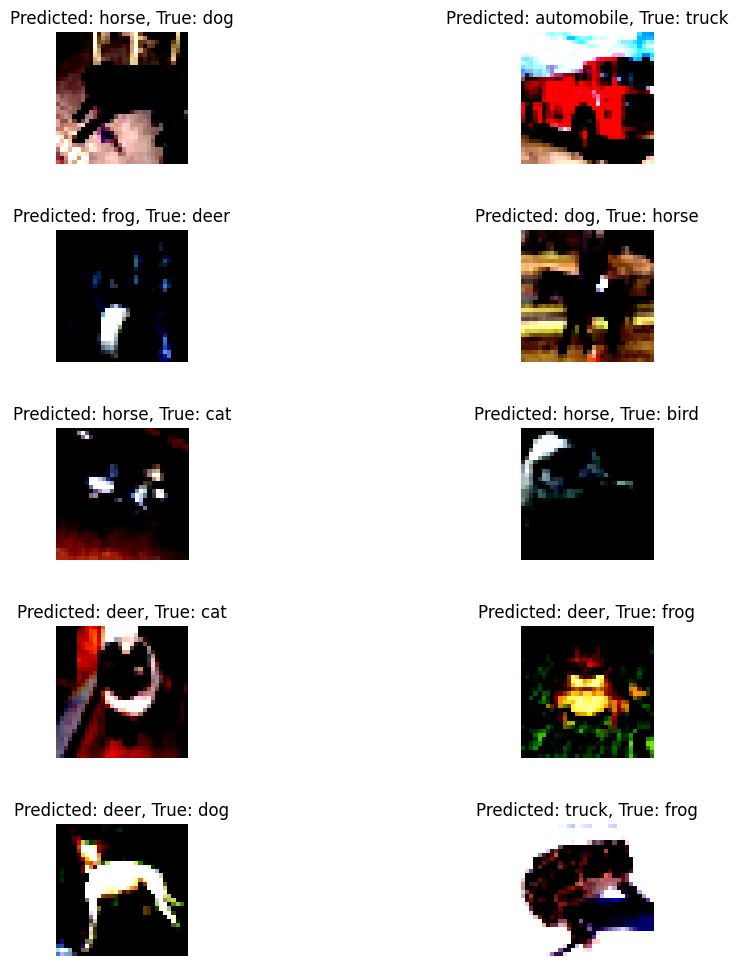

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_misclassified_images(images, pred_labels, true_labels):
    fig, axs = plt.subplots(5, 2, figsize=(10, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    axs = axs.ravel()

    for i in range(len(images)):
        pred_class_name = class_names[pred_labels[i]]
        true_class_name = class_names[true_labels[i]]

        axs[i].imshow(images[i].permute(1, 2, 0).cpu().clamp(0,1))
        axs[i].set_title(f'Predicted: {pred_class_name}, True: {true_class_name}')
        axs[i].axis('off')

    plt.show()

visualize_misclassified_images(misclassified_images[:10], misclassified_pred_labels[:10], misclassified_true_labels[:10])

In [18]:
train_losses_tensor = torch.tensor(train_losses).cuda()
train_losses_tensor = train_losses_tensor.cpu().numpy()

train_acc_tensor = torch.tensor(train_acc).cuda()
train_acc_tensor = train_acc_tensor.cpu().numpy()

test_losses_tensor = torch.tensor(test_losses).cuda()
test_losses_tensor = test_losses_tensor.cpu().numpy()

test_acc_tensor = torch.tensor(test_acc).cuda()
test_acc_tensor = test_acc_tensor.cpu().numpy()

Text(0.5, 1.0, 'Test Accuracy')

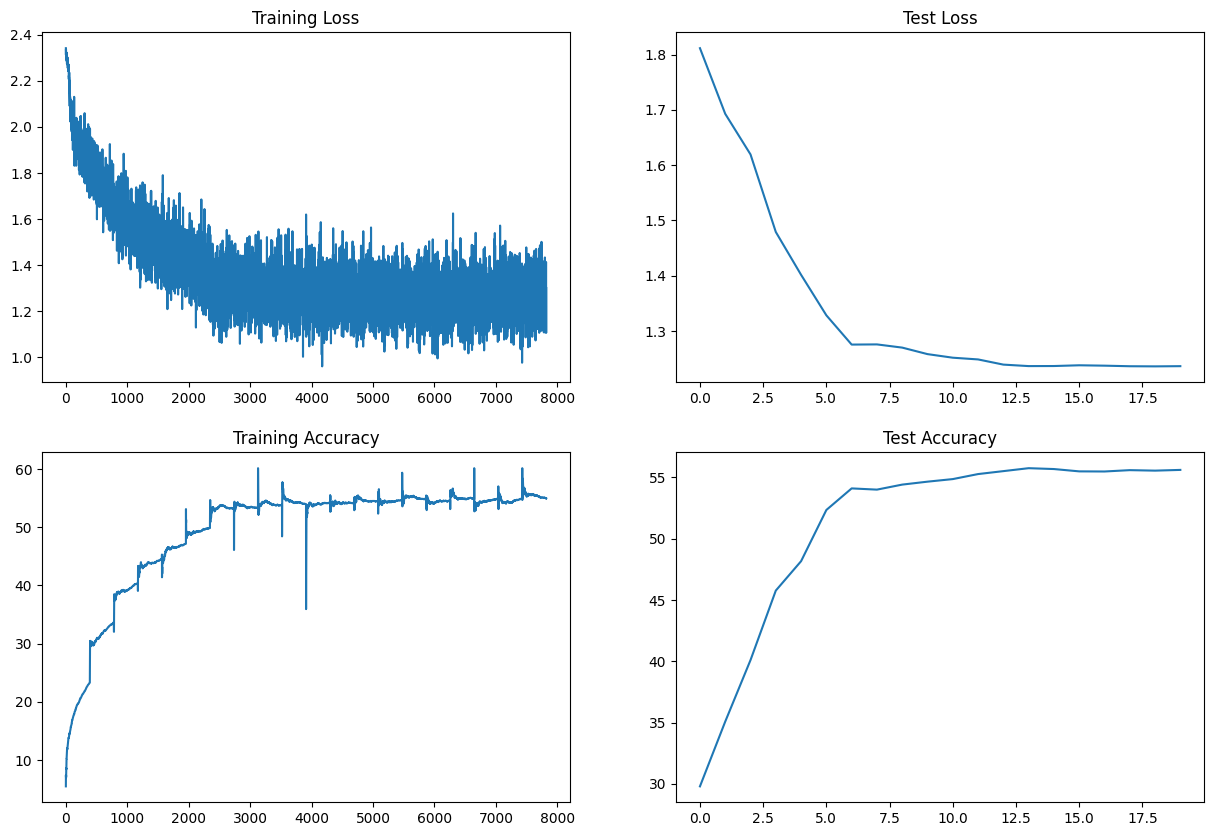

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_tensor)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_tensor)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_tensor)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_tensor)
axs[1, 1].set_title("Test Accuracy")